In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)
torch_version = torch.__version__
cuda_version = torch.version.cuda.replace('.', '')
base_url = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"

In [ ]:
# print(base_url)

In [ ]:
# Install PyTorch Geometric and its dependencies
!pip install -q torch-scatter -f $base_url
!pip install -q torch-sparse -f $base_url
!pip install -q torch-cluster -f $base_url
!pip install -q torch-spline-conv -f $base_url
!pip install -q torch-geometric

In [ ]:
# Install Biopython for PDBParser
!pip install biopython

In [ ]:
import torch
import torch.utils.data as data
import torch_geometric
import torch_cluster
import torch.nn.functional as F
from Bio.PDB import PDBParser, Polypeptide
import numpy as np
import tqdm
import random
import math
import re
import torch, functools
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_scatter import scatter_add
import torch.nn as nn
from torch.distributions import Categorical
from torch_scatter import scatter_mean
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
seeds = [0,1,2,42,1234]
seed=seeds[0]
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
def _normalize(tensor, dim=-1):
    return torch.nan_to_num(torch.div(tensor, torch.norm(tensor, dim=dim, keepdim=True)))

def _rbf(D, D_min=0., D_max=20., D_count=16, device='cpu'):
    D_mu = torch.linspace(D_min, D_max, D_count, device=device)
    D_mu = D_mu.view([1, -1])
    D_sigma = (D_max - D_min) / D_count
    D_expand = torch.unsqueeze(D, -1)
    RBF = torch.exp(-((D_expand - D_mu) / D_sigma) ** 2)
    return RBF

def parse_fasta(fasta_file):
    data_info = {}
    current_idx = None

    with open(fasta_file, 'r') as file:
        for line in file:
            line = line.strip()  # Remove newline and trailing spaces
            if line.startswith('>'):
                # Parse the header line
                match = re.match(r'>Sequence(\d+) TARGET=([\d.]+) SET=(\w+) VALIDATION=False', line)
                if match:
                    current_idx, target, set_type = int(match.group(1)), float(match.group(2)), match.group(3)
                    data_info[current_idx] = {'target': target, 'set': set_type, 'sequence': ''}
            else:
                # Read sequence line and append it to the current sequence
                if current_idx is not None:
                    data_info[current_idx]['sequence'] += line

    return data_info

In [ ]:
def custom_collate(batch):
    # Use torch_geometric.data.Batch.from_data_list to handle standard attributes
    batched_data = torch_geometric.data.Batch.from_data_list(batch)

    # Additional attributes (target, seq_tensor, mask, name) need to be handled separately
    targets = torch.tensor([item.target for item in batch], dtype=torch.float32)
    names = [item.name for item in batch]
    seq_tensors = torch.cat([item.seq for item in batch], dim=0)
    masks = torch.cat([item.mask for item in batch], dim=0)

    # Add these attributes to the batched_data
    batched_data.target = targets
    batched_data.name = names
    batched_data.seq = seq_tensors
    batched_data.mask = masks

    return batched_data

In [ ]:
class BatchSampler(data.Sampler):
    def __init__(self, node_counts, max_nodes=3000, shuffle=True):
        self.node_counts = node_counts
        self.idx = [i for i in range(len(node_counts)) if node_counts[i] <= max_nodes]
        self.shuffle = shuffle
        self.max_nodes = max_nodes
        self._form_batches()

    def _form_batches(self):
        self.batches = []
        if self.shuffle: random.shuffle(self.idx)
        idx = self.idx
        while idx:
            batch = []
            n_nodes = 0
            while idx and n_nodes + self.node_counts[idx[0]] <= self.max_nodes:
                next_idx, idx = idx[0], idx[1:]
                n_nodes += self.node_counts[next_idx]
                batch.append(next_idx)
            self.batches.append(batch)

    def __len__(self):
        if not self.batches: self._form_batches()
        return len(self.batches)

    def __iter__(self):
        if not self.batches: self._form_batches()
        for batch in self.batches: yield batch

In [ ]:
class ProteinGraphDataset(data.Dataset):
    def __init__(self, pdb_files, data_info, split, use_embeddings=False, embeddings=None, embedding_dim=1280, top_k=32, num_rbf=16, num_positional_embeddings=16, device="cpu"):
        self.pdb_files = pdb_files
        self.use_embeddings = use_embeddings
        if use_embeddings and embeddings is not None:
            self.embeddings = embeddings
        self.data_info = data_info
        self.split = split
        self.embedding_dim = embedding_dim
        self.top_k = top_k
        self.num_rbf = num_rbf
        self.num_positional_embeddings = num_positional_embeddings
        self.device = device
        self.selected_indices = [idx for idx, info in data_info.items() if info['set'] == split]
        self.graph_cache = {}
        self.letter_to_num = {'C': 4, 'D': 3, 'S': 15, 'Q': 5, 'K': 11, 'I': 9,
                              'P': 14, 'T': 16, 'F': 13, 'A': 0, 'G': 7, 'H': 8,
                              'E': 6, 'L': 10, 'R': 1, 'W': 17, 'V': 19,
                              'N': 2, 'Y': 18, 'M': 12}

    def __len__(self):
        return len(self.selected_indices)

    def __getitem__(self, idx):
        if idx in self.graph_cache:
            return self.graph_cache[idx]
        actual_idx = self.selected_indices[idx]
        target = self.data_info[actual_idx]['target']
        pdb_file = self.pdb_files[actual_idx]
        coords = self._parse_pdb(pdb_file)  # Directly returns coords
        # coords, pdb_sequence = self._parse_pdb(pdb_file)
        # assert pdb_sequence == self.data_info[actual_idx]['sequence'], f"Sequence mismatch for index {idx}"
        # print(pdb_sequence == self.data_info[actual_idx]['sequence'])
        graph = self._featurize_as_graph(coords, actual_idx)

        # Create a Data object to hold both the graph and the target, along with seq and mask
        data = torch_geometric.data.Data(
            x=graph.x,
            seq=graph.seq_tensor,
            name = graph.name,
            node_s=graph.node_s,
            node_v=graph.node_v,
            edge_s=graph.edge_s,
            edge_v=graph.edge_v,
            edge_index=graph.edge_index,
            mask=graph.mask,
            target=target,  # Include the target in the Data object
        )
        # data = torch_geometric.data.Data(x=X_ca, seq=seq, name=name,
        #                                  node_s=node_s, node_v=node_v,
        #                                  edge_s=edge_s, edge_v=edge_v,
        #                                  edge_index=edge_index, mask=mask)

        self.graph_cache[idx] = data
        return data

    def _parse_pdb(self, pdb_file):
        parser = PDBParser()
        structure = parser.get_structure(pdb_file, pdb_file)

        # Initializing a dictionary to store the coordinates of each required atom type
        coords = {'N': [], 'CA': [], 'C': [], 'O': []}

        for model in structure:
            for chain in model:
                for residue in chain:
                    # A temporary storage for the current residue's atoms
                    residue_coords = {'N': None, 'CA': None, 'C': None, 'O': None}

                    for atom in residue:
                        if atom.get_name() in residue_coords:
                            residue_coords[atom.get_name()] = atom.get_coord()

                    # If all required atoms are present, add their coordinates
                    if all(atom in residue_coords and residue_coords[atom] is not None for atom in ['N', 'CA', 'C', 'O']):
                        for atom in ['N', 'CA', 'C', 'O']:
                            coords[atom].append(residue_coords[atom])

        # Convert lists to numpy arrays and then to tensors, maintaining the atom type order
        coords = {atom: torch.tensor(np.array(coords[atom]), device=self.device, dtype=torch.float32) for atom in ['N', 'CA', 'C', 'O']}

        return coords


    def _featurize_as_graph(self, coords, idx):
        with torch.no_grad():
            # Convert coordinates to tensors and move to the specified device
            coords = {k: torch.tensor(v, device=self.device, dtype=torch.float32).clone().detach() for k, v in coords.items()}
            seq = [self.letter_to_num.get(amino_acid, -1) for amino_acid in self.data_info[idx]['sequence']]
            seq_tensor = torch.tensor(seq, dtype=torch.long, device=self.device)

            # Combining all atom coordinates into a single tensor
            all_coords = torch.stack([coords['N'], coords['CA'], coords['C'], coords['O']], dim=1)

            # Generate mask and update coordinates
            mask = torch.isfinite(all_coords.sum(dim=(1, 2)))
            all_coords[~mask] = np.inf  # Handle non-finite values

            # Extract 'CA' coordinates for graph construction
            X_ca = all_coords[:, 1]

            # Graph connectivity based on nearest neighbors in the CA coordinates
            edge_index = torch_cluster.knn_graph(X_ca, k=self.top_k)

            # Edge features
            E_vectors = X_ca[edge_index[0]] - X_ca[edge_index[1]]
            rbf = _rbf(E_vectors.norm(dim=-1), D_count=self.num_rbf, device=self.device)

            # Node features: dihedrals and sequence embeddings
            dihedrals = self._dihedrals(coords)
            if self.use_embeddings:
                sequence_embeddings = self.embeddings[f'Sequence{idx}']
                #print(sequence_embeddings.shape)
                assert sequence_embeddings.shape[0] == len(coords['CA']), "Mismatch in number of amino acids in structure and embeddings"
                # Scale sequence embeddings to [-1, 1]
                min_val = sequence_embeddings.min()
                max_val = sequence_embeddings.max()
                sequence_embeddings = 2 * ((sequence_embeddings - min_val) / (max_val - min_val)) - 1
                node_s = torch.cat([dihedrals, sequence_embeddings], dim=-1)
            else:
                node_s = dihedrals

            # Additional node features: orientations and sidechains
            orientations = self._orientations(X_ca)
            sidechains = self._sidechains(coords['N'], coords['CA'], coords['C'])
            node_v = torch.cat([orientations, sidechains.unsqueeze(-2)], dim=-2)

            # Positional embeddings for edges
            pos_embeddings = self._positional_embeddings(edge_index)
            edge_s = torch.cat([rbf, pos_embeddings], dim=-1)
            edge_v = _normalize(E_vectors).unsqueeze(-2)

            # Apply nan_to_num to all features
            node_s, node_v, edge_s, edge_v = map(torch.nan_to_num, (node_s, node_v, edge_s, edge_v))

        # Create graph data
        data = torch_geometric.data.Data(x=X_ca,
                                         seq_tensor = seq_tensor,
                                         name=f'Sequence{idx}',
                                         node_s=node_s,
                                         node_v=node_v,
                                         edge_s=edge_s,
                                         edge_v=edge_v,
                                         edge_index=edge_index,
                                         mask = mask
                                         )
        # data = torch_geometric.data.Data(x=X_ca, seq=seq, name=name,
        #                                  node_s=node_s, node_v=node_v,
        #                                  edge_s=edge_s, edge_v=edge_v,
        #                                  edge_index=edge_index, mask=mask)
        return data


    def _dihedrals(self, coords, eps=1e-7):
        X = torch.cat([torch.tensor(coords['N'], dtype=torch.float32, device=self.device).clone().detach(),
                       torch.tensor(coords['CA'], dtype=torch.float32, device=self.device).clone().detach(),
                       torch.tensor(coords['C'], dtype=torch.float32, device=self.device).clone().detach()], dim=0)


        dX = X[1:] - X[:-1]
        U = _normalize(dX, dim=-1)
        u_2 = U[:-2]; u_1 = U[1:-1]; u_0 = U[2:]

        n_2 = _normalize(torch.cross(u_2, u_1), dim=-1)
        n_1 = _normalize(torch.cross(u_1, u_0), dim=-1)

        cosD = torch.sum(n_2 * n_1, -1)
        cosD = torch.clamp(cosD, -1 + eps, 1 - eps)
        D = torch.sign(torch.sum(u_2 * n_1, -1)) * torch.acos(cosD)

        D = F.pad(D, [1, 2])
        D = torch.reshape(D, [-1, 3])
        D_features = torch.cat([torch.cos(D), torch.sin(D)], 1)
        return D_features

    def _positional_embeddings(self, edge_index, num_embeddings=None, period_range=[2, 1000]):
        num_embeddings = num_embeddings or self.num_positional_embeddings
        d = edge_index[0] - edge_index[1]

        frequency = torch.exp(torch.arange(0, num_embeddings, 2, dtype=torch.float32, device=self.device)
                              * -(np.log(10000.0) / num_embeddings))
        angles = d.unsqueeze(-1) * frequency
        E = torch.cat((torch.cos(angles), torch.sin(angles)), -1)
        return E

    def _orientations(self, X_ca):
        forward = _normalize(X_ca[1:] - X_ca[:-1])
        backward = _normalize(X_ca[:-1] - X_ca[1:])
        forward = F.pad(forward, [0, 0, 0, 1])
        backward = F.pad(backward, [0, 0, 1, 0])
        return torch.cat([forward.unsqueeze(-2), backward.unsqueeze(-2)], -2)

    def _sidechains(self, N, CA, C):
        n = _normalize(torch.tensor(N, dtype=torch.float32, device=self.device) - torch.tensor(CA, dtype=torch.float32, device=self.device))
        c = _normalize(torch.tensor(C, dtype=torch.float32, device=self.device) - torch.tensor(CA, dtype=torch.float32, device=self.device))
        bisector = _normalize(c + n)
        perp = _normalize(torch.cross(c, n))
        vec = -bisector * math.sqrt(1 / 3) - perp * math.sqrt(2 / 3)
        return vec

In [ ]:
# pdb_folder_path = '/content/drive/MyDrive/function_predictor/GB1-Dataset-FewToMore/test_omegaf_predictions/'
# embeddings_path = '/content/drive/MyDrive/function_predictor/GB1-Dataset-FewToMore/emb_residue_level_embedding_GB1_embedding_ESM_2_650_embeddings_tensor.pt'
# split_fasta_file_path = '/content/drive/MyDrive/function_predictor/GB1-Dataset-FewToMore/data_loading_test.fasta'

In [ ]:
# embeddings = torch.load(embeddings_path, map_location=device)

In [ ]:
# embeddings['Sequence0'].size()

In [ ]:
# data_info = parse_fasta(split_fasta_file_path)

In [ ]:
# pdb_files = [pdb_folder_path + f'Sequence{i}.pdb' for i in range(6)]

In [ ]:
# #train_dataset = ProteinGraphDataset(pdb_files, embeddings, data_info, 'train', device=device)
# train_dataset= ProteinGraphDataset(pdb_files, data_info, 'train', use_embeddings=True, embeddings = embeddings, device = device)
# #test_dataset = ProteinGraphDataset(pdb_files, embeddings, data_info, 'test', device=device)
# test_dataset= ProteinGraphDataset(pdb_files, data_info, 'test', use_embeddings=True, embeddings = embeddings, device = device)

Use Batch Sampler while loading the code later.

In [ ]:
# node_counts_train = [len(train_dataset[i].x) for i in range(len(train_dataset))]

In [ ]:
# batch_sampler_train = BatchSampler(node_counts_train)

In [ ]:
# node_counts_test = [len(test_dataset[i].x) for i in range(len(test_dataset))]

In [ ]:
# batch_sampler_test = BatchSampler(node_counts_test)

In [ ]:
# # DataLoader for training
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=batch_sampler_train, collate_fn=custom_collate)
# # DataLoader for testing
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=batch_sampler_test, collate_fn=custom_collate)

In [ ]:
# for data in train_loader:
#     data1 = data
#     break

In [ ]:
# data1.node_s.size()

In [ ]:
# data1.node_v.size()

In [ ]:
# data1.edge_s.size()

In [ ]:
# data.edge_v.size()

In [ ]:
# data.edge_index.size()

In [ ]:
# tup1 = (data1.node_s, data1.node_v)

In [ ]:
# s, v = [1286, 0]
# print(s)
# print(v)

In [ ]:
# import torch

# def check_tensor_shapes(data):
#     # Check node scalar and vector feature dimensions
#     assert data.x.shape[-1] == 3, f"x last dimension mismatch: {data.x.shape}"
#     assert data.node_s.shape[-1] == 1286, f"node_s last dimension mismatch: {data.node_s.shape}" # 6 if use_embeddings == False
#     assert data.node_v.shape[-2:] == (3, 3), f"node_v last two dimensions mismatch: {data.node_v.shape}"

#     # Check edge scalar and vector feature dimensions
#     assert data.edge_s.shape[-1] == 32, f"edge_s last dimension mismatch: {data.edge_s.shape}"
#     assert data.edge_v.shape[-2:] == (1, 3), f"edge_v last two dimensions mismatch: {data.edge_v.shape}"

#     # Check edge index dimension
#     assert data.edge_index.shape[0] == 2, f"edge_index first dimension mismatch: {data.edge_index.shape}"
#     assert len(data.edge_index.shape) == 2, f"edge_index dimension mismatch: {data.edge_index.shape}"

#     print("All tensor dimensions are correct.")

# def validate_vector_dimensions(data):
#     # Ensuring that vector channels are the last dimension
#     assert data.node_v.shape[-1] == 3, "node_v last dimension is not 3"
#     assert data.edge_v.shape[-1] == 3, "edge_v last dimension is not 3"

#     print("All vector dimensions are validated.")

# # Example of how to use these functions after loading a batch of data
# # Let's assume you have a data object from your dataset
# data = train_dataset[1]  # Assuming the first item from your dataset

# check_tensor_shapes(data)
# validate_vector_dimensions(data)

## Tuple Helper Functions


In [ ]:
def tuple_sum(*args):
    '''
    Sums any number of tuples (s, V) elementwise.

    Parameters:
        *args: A variable number of tuples to be summed.

    Returns:
        A single tuple containing the element-wise sum of all input tuples.

    Example:
        >>> tuple_sum((1, 2), (3, 4), (5, 6))
        (9, 12)

        This example demonstrates the addition of three tuples: (1, 2), (3, 4), and (5, 6).
        The function sums the first elements of all tuples (1 + 3 + 5) and the second elements (2 + 4 + 6),
        resulting in the tuple (9, 12).
    '''
    return tuple(map(sum, zip(*args)))


def tuple_cat(*args, dim=-1):
    '''
    Concatenates any number of tuples (s, V) elementwise, where each tuple contains two tensors.

    Parameters:
        *args: A variable number of tuples, where each tuple contains two tensors to be concatenated.
        dim (int): The dimension along which to concatenate. For scalar-channel tensors (`s`),
                   `dim` refers to the dimension in `s`. For vector-channel tensors (`V`),
                   `dim` (when set to -1) is equivalent to `dim=-2`, accounting for the additional
                   channel dimension in `V`.

    Returns:
        A single tuple containing two tensors, which are the concatenations of the first and second elements
        from each input tuple, respectively.

    Dimension Explanation:
        - For a tensor `t` in the scalar-channel tuple (first element), `t[dim]` refers to the dimension along
          which the concatenation occurs. If `t` is 1D, `dim=0` would be the length of `t`.
        - For a tensor `t` in the vector-channel tuple (second element), the tensor is considered to have an
          additional channel dimension. Thus, `dim=-1` for scalar-channel is equivalent to `dim=-2` for
          vector-channel, meaning the last spatial dimension before the channel dimension.

    Example:
        >>> import torch
        >>> t1 = (torch.tensor([1, 2]), torch.tensor([[1, 2], [3, 4]]))
        >>> t2 = (torch.tensor([3, 4]), torch.tensor([[5, 6], [7, 8]]))
        >>> tuple_cat(t1, t2, dim=0)
        (tensor([1, 2, 3, 4]), tensor([[1, 2], [3, 4], [5, 6], [7, 8]]))

        In this example, the scalar-channel tensors [1, 2] and [3, 4] are concatenated along dim=0,
        resulting in [1, 2, 3, 4]. The vector-channel tensors are 2x2 matrices concatenated along
        the first dimension (rows), resulting in a 4x2 matrix.
    '''
    dim %= len(args[0][0].shape)
    s_args, v_args = list(zip(*args))
    return torch.cat(s_args, dim=dim), torch.cat(v_args, dim=dim)


def tuple_index(x, idx):
    '''
    Indexes into a tuple (s, V) of two tensors along the first dimension.

    This function allows indexing into each tensor of the tuple using the provided index.
    It is equivalent to applying the indexing operation on each tensor individually.

    Parameters:
        x (tuple): A tuple of two tensors (s, V) where `s` is a scalar-channel tensor
                   and `V` is a vector-channel tensor.
        idx (int, slice, tensor, list): An index or a slice object or any other legitimate
                                        indexer used in PyTorch for indexing into tensors.
                                        This will be applied to each tensor in the tuple.

    Returns:
        tuple: A tuple of two tensors, each being the result of indexing the corresponding
               tensor in `x` with `idx`.

    Example:
        >>> import torch
        >>> s = torch.tensor([1, 2, 3])
        >>> V = torch.tensor([[1, 2], [3, 4], [5, 6]])
        >>> x = (s, V)
        >>> tuple_index(x, 1)
        (2, tensor([3, 4]))

        In this example, indexing with `1` extracts the second element of the tensor `s` and
        the second row of the tensor `V`. Hence, the result is (2, tensor([3, 4])).

    '''
    return x[0][idx], x[1][idx]


def randn(n, dims, device="cpu"):
    '''
    Returns random tuples (s, V) drawn elementwise from a normal distribution.

    This function generates two tensors. The first tensor `s` contains scalar values and the second tensor `V` contains vector values.
    Each element in these tensors is drawn from a standard normal distribution.

    Parameters:
        n (int): The number of data points, which corresponds to the size of the first dimension in both tensors.
        dims (tuple): A tuple (n_scalar, n_vector) specifying the dimensions.
                      `n_scalar` is the number of scalar values per data point, and `n_vector` is the number of vector values per data point.
        device (str): The device to store the tensors on. Default is "cpu".

    Returns:
        tuple: A tuple (s, V) where `s` is a tensor with shape (n, n_scalar) containing scalar values,
               and `V` is a tensor with shape (n, n_vector, 3) containing vector values.

    Example:
        >>> randn(4, (2, 3))
        (tensor([[ 0.4963, -0.1383], [-0.2341,  1.5792], [ 0.7674, -0.4695], [ 0.5426, -0.4634]]),
         tensor([[[-1.5610, -0.3252,  1.0913],
                  [-1.3120,  0.0693,  0.1527],
                  [-0.1646, -0.4303,  0.7674]],

                 [[-0.4695,  0.5426, -0.4634],
                  [ 0.4963, -0.1383,  0.4963],
                  [ 0.4963, -0.1383,  0.4963]],

                 [[ 0.4963, -0.1383,  0.4963],
                  [ 0.4963, -0.1383,  0.4963],
                  [ 0.4963, -0.1383,  0.4963]],

                 [[ 0.4963, -0.1383,  0.4963],
                  [ 0.4963, -0.1383,  0.4963],
                  [ 0.4963, -0.1383,  0.4963]]]))

    In this example, calling `randn(4, (2, 3))` will generate a tuple of two tensors.
    The first tensor `s` will have the shape (4, 2) and the second tensor `V` will have the shape (4, 3, 3),
    with all elements drawn from a standard normal distribution.
    '''
    return torch.randn(n, dims[0], device=device), torch.randn(n, dims[1], 3, device=device)


def _norm_no_nan(x, axis=-1, keepdims=False, eps=1e-8, sqrt=True):
    '''
    Calculates the L2 norm of a tensor, clamped to a minimum value of `eps` to avoid division by zero or NaN values.
    Optionally, the square of the L2 norm can be returned.

    Parameters:
        x (Tensor): The input tensor.
        axis (int): The dimension along which to compute the norm. Default is -1, which means the last dimension.
        keepdims (bool): If True, the output tensor will keep the dimension of size one along the specified axis;
                         otherwise, the dimension is squeezed. Default is False.
        eps (float): A small value to clamp the norm result to avoid NaN or infinite values. Default is 1e-8.
        sqrt (bool): If True, returns the square root of the sum of squares (L2 norm); if False, returns
                     the sum of squares without taking the square root. Default is True.

    Returns:
        Tensor: The L2 norm of the tensor, clamped to a minimum value of `eps`.

    Example:
        >>> x = torch.tensor([[1, 2, 3], [4, 5, 6]])
        >>> _norm_no_nan(x, axis=1, sqrt=True)
        tensor([3.7417, 8.7749])

        In this example, the function calculates the L2 norm along axis 1 for each row in the tensor `x`.
        The norms are [sqrt(1^2 + 2^2 + 3^2), sqrt(4^2 + 5^2 + 6^2)] = [3.7417, 8.7749], avoiding any NaN values
        by clamping the minimum norm value to `eps`.
    '''
    out = torch.clamp(torch.sum(torch.square(x), axis, keepdims), min=eps)
    return torch.sqrt(out) if sqrt else out


def _split(x, nv):
    '''
    Splits a merged tensor representation of a tuple (s, V) back into the tuple format. This function should
    be used to reverse the operation performed by `_merge(s, V)`. It's specifically designed for scenarios where
    working with a merged representation is necessary, and later the original tuple format is required.

    Parameters:
        x (Tensor): A merged tensor representation of (s, V), where `V` vector channels are flattened and
                    appended to `s` scalar channels. This is the output from `_merge`.
        nv (int): The number of vector channels in `V` before the merge. This is used to correctly split
                  the tensor back into scalar and vector components.

    Returns:
        tuple: A tuple (s, V), where `s` is the tensor of scalar channels, and `V` is the tensor of vector
               channels with the original shape.

    Example:
        >>> s = torch.tensor([1, 2, 3])
        >>> V = torch.tensor([[4, 5, 6], [7, 8, 9]])
        >>> x = _merge(s, V)
        >>> _split(x, 2)
        (tensor([1, 2, 3]), tensor([[4, 5, 6], [7, 8, 9]]))

        After merging `s` and `V` into `x`, `_split` correctly separates them back into the original `s` and `V` tensors.
    '''
    v = torch.reshape(x[..., -3*nv:], x.shape[:-1] + (nv, 3))
    s = x[..., :-3*nv]
    return s, v

def _merge(s, v):
    '''
    Merges a tuple (s, V) into a single `torch.Tensor` by flattening the vector channels `V` and
    appending them to the scalar channels `s`. This function is useful for operations that require
    a unified tensor representation instead of separate scalar and vector components. To revert to the
    original tuple format, use `_split(x, nv)`.

    Parameters:
        s (Tensor): The tensor of scalar channels.
        v (Tensor): The tensor of vector channels.

    Returns:
        Tensor: A single tensor where the vector channels are flattened and concatenated to the scalar channels.

    Example:
        >>> s = torch.tensor([1, 2, 3])
        >>> V = torch.tensor([[4, 5, 6], [7, 8, 9]])
        >>> _merge(s, V)
        tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])

        The `V` tensor is flattened and appended to the `s` tensor to form a single concatenated tensor.
    '''
    v = torch.reshape(v, v.shape[:-2] + (3*v.shape[-2],))
    return torch.cat([s, v], -1)

## GVP

In [ ]:
class GVP(nn.Module):
    '''
    Geometric Vector Perceptron. See manuscript and README.md
    for more details.

    :param in_dims: tuple (n_scalar, n_vector)
    :param out_dims: tuple (n_scalar, n_vector)
    :param h_dim: intermediate number of vector channels, optional
    :param activations: tuple of functions (scalar_act, vector_act)
    :param vector_gate: whether to use vector gating.
                        (vector_act will be used as sigma^+ in vector gating if `True`)
    '''
    def __init__(self, in_dims, out_dims, h_dim=None,
                 activations=(F.relu, torch.sigmoid), vector_gate=False):
        super(GVP, self).__init__()
        self.si, self.vi = in_dims
        self.so, self.vo = out_dims
        self.vector_gate = vector_gate
        if self.vi:
            self.h_dim = h_dim or max(self.vi, self.vo)
            self.wh = nn.Linear(self.vi, self.h_dim, bias=False)
            self.ws = nn.Linear(self.h_dim + self.si, self.so)
            if self.vo:
                self.wv = nn.Linear(self.h_dim, self.vo, bias=False)
                if self.vector_gate: self.wsv = nn.Linear(self.so, self.vo)
        else:
            self.ws = nn.Linear(self.si, self.so)

        self.scalar_act, self.vector_act = activations
        self.dummy_param = nn.Parameter(torch.empty(0))

    def forward(self, x):
        '''
        :param x: tuple (s, V) of `torch.Tensor`,
                  or (if vectors_in is 0), a single `torch.Tensor`
        :return: tuple (s, V) of `torch.Tensor`,
                 or (if vectors_out is 0), a single `torch.Tensor`
        '''
        if self.vi:
            s, v = x
            v = torch.transpose(v, -1, -2)
            vh = self.wh(v)
            vn = _norm_no_nan(vh, axis=-2)
            s = self.ws(torch.cat([s, vn], -1))
            if self.vo:
                v = self.wv(vh)
                v = torch.transpose(v, -1, -2)
                if self.vector_gate:
                    if self.vector_act:
                        gate = self.wsv(self.vector_act(s))
                    else:
                        gate = self.wsv(s)
                    v = v * torch.sigmoid(gate).unsqueeze(-1)
                elif self.vector_act:
                    v = v * self.vector_act(
                        _norm_no_nan(v, axis=-1, keepdims=True))
        else:
            s = self.ws(x)
            if self.vo:
                v = torch.zeros(s.shape[0], self.vo, 3,
                                device=self.dummy_param.device)
        if self.scalar_act:
            s = self.scalar_act(s)

        return (s, v) if self.vo else s

## Vector Dropout

In [ ]:
class _VDropout(nn.Module):
    '''
    Vector channel dropout where the elements of each
    vector channel are dropped together.
    '''
    def __init__(self, drop_rate):
        super(_VDropout, self).__init__()
        self.drop_rate = drop_rate
        self.dummy_param = nn.Parameter(torch.empty(0))

    def forward(self, x):
        '''
        :param x: `torch.Tensor` corresponding to vector channels
        '''
        device = self.dummy_param.device
        if not self.training:
            return x
        mask = torch.bernoulli(
            (1 - self.drop_rate) * torch.ones(x.shape[:-1], device=device)
        ).unsqueeze(-1)
        x = mask * x / (1 - self.drop_rate)
        return x

## Combined scalar-vector tuple dropout

In [ ]:
class Dropout(nn.Module):
    '''
    Combined dropout for tuples (s, V).
    Takes tuples (s, V) as input and as output.
    '''
    def __init__(self, drop_rate):
        super(Dropout, self).__init__()
        self.sdropout = nn.Dropout(drop_rate)
        self.vdropout = _VDropout(drop_rate)

    def forward(self, x):
        '''
        :param x: tuple (s, V) of `torch.Tensor`,
                  or single `torch.Tensor`
                  (will be assumed to be scalar channels)
        '''
        if type(x) is torch.Tensor:
            return self.sdropout(x)
        s, v = x
        return self.sdropout(s), self.vdropout(v)

## Layer Normalization for scalar-vector tuple

In [ ]:
class LayerNorm(nn.Module):
    '''
    Combined LayerNorm for tuples (s, V).
    Takes tuples (s, V) as input and as output.
    '''
    def __init__(self, dims):
        super(LayerNorm, self).__init__()
        self.s, self.v = dims
        self.scalar_norm = nn.LayerNorm(self.s)

    def forward(self, x):
        '''
        :param x: tuple (s, V) of `torch.Tensor`,
                  or single `torch.Tensor`
                  (will be assumed to be scalar channels)
        '''
        if not self.v:
            return self.scalar_norm(x)
        s, v = x
        vn = _norm_no_nan(v, axis=-1, keepdims=True, sqrt=False)
        vn = torch.sqrt(torch.mean(vn, dim=-2, keepdim=True))
        return self.scalar_norm(s), v / vn

## Graph Convolution Step

In [ ]:
class GVPConv(MessagePassing):
    '''
    Graph convolution / message passing with Geometric Vector Perceptrons.
    Takes in a graph with node and edge embeddings,
    and returns new node embeddings.

    This does NOT do residual updates and pointwise feedforward layers
    ---see `GVPConvLayer`.

    :param in_dims: input node embedding dimensions (n_scalar, n_vector)
    :param out_dims: output node embedding dimensions (n_scalar, n_vector)
    :param edge_dims: input edge embedding dimensions (n_scalar, n_vector)
    :param n_layers: number of GVPs in the message function
    :param module_list: preconstructed message function, overrides n_layers
    :param aggr: should be "add" if some incoming edges are masked, as in
                 a masked autoregressive decoder architecture, otherwise "mean"
    :param activations: tuple of functions (scalar_act, vector_act) to use in GVPs
    :param vector_gate: whether to use vector gating.
                        (vector_act will be used as sigma^+ in vector gating if `True`)
    '''
    def __init__(self, in_dims, out_dims, edge_dims,
                 n_layers=3, module_list=None, aggr="mean",
                 activations=(F.relu, torch.sigmoid), vector_gate=False):
        super(GVPConv, self).__init__(aggr=aggr)
        self.si, self.vi = in_dims
        self.so, self.vo = out_dims
        self.se, self.ve = edge_dims

        GVP_ = functools.partial(GVP,
                activations=activations, vector_gate=vector_gate)

        module_list = module_list or []
        if not module_list:
            if n_layers == 1:
                module_list.append(
                    GVP_((2*self.si + self.se, 2*self.vi + self.ve),
                        (self.so, self.vo), activations=(None, None)))
            else:
                module_list.append(
                    GVP_((2*self.si + self.se, 2*self.vi + self.ve), out_dims)
                )
                for i in range(n_layers - 2):
                    module_list.append(GVP_(out_dims, out_dims))
                module_list.append(GVP_(out_dims, out_dims,
                                       activations=(None, None)))
        self.message_func = nn.Sequential(*module_list)

    def forward(self, x, edge_index, edge_attr):
        '''
        :param x: tuple (s, V) of `torch.Tensor`
        :param edge_index: array of shape [2, n_edges]
        :param edge_attr: tuple (s, V) of `torch.Tensor`
        '''
        # x_s, x_v = x['node_s'], x['node_v']
        x_s, x_v = x
        message = self.propagate(edge_index,
                    s=x_s, v=x_v.reshape(x_v.shape[0], 3*x_v.shape[1]),
                    edge_attr=edge_attr)
        return _split(message, self.vo)

    def message(self, s_i, v_i, s_j, v_j, edge_attr):
        v_j = v_j.view(v_j.shape[0], v_j.shape[1]//3, 3)
        v_i = v_i.view(v_i.shape[0], v_i.shape[1]//3, 3)
        message = tuple_cat((s_j, v_j), edge_attr, (s_i, v_i))
        message = self.message_func(message)
        return _merge(*message)

## GCN Layer

In [ ]:
class GVPConvLayer(nn.Module):
    '''
    Full graph convolution / message passing layer with
    Geometric Vector Perceptrons. Residually updates node embeddings with
    aggregated incoming messages, applies a pointwise feedforward
    network to node embeddings, and returns updated node embeddings.

    To only compute the aggregated messages, see `GVPConv`.

    :param node_dims: node embedding dimensions (n_scalar, n_vector)
    :param edge_dims: input edge embedding dimensions (n_scalar, n_vector)
    :param n_message: number of GVPs to use in message function
    :param n_feedforward: number of GVPs to use in feedforward function
    :param drop_rate: drop probability in all dropout layers
    :param autoregressive: if `True`, this `GVPConvLayer` will be used
           with a different set of input node embeddings for messages
           where src >= dst
    :param activations: tuple of functions (scalar_act, vector_act) to use in GVPs
    :param vector_gate: whether to use vector gating.
                        (vector_act will be used as sigma^+ in vector gating if `True`)
    '''
    def __init__(self, node_dims, edge_dims,
                 n_message=3, n_feedforward=2, drop_rate=.1,
                 autoregressive=False,
                 activations=(F.relu, torch.sigmoid), vector_gate=False):

        super(GVPConvLayer, self).__init__()
        self.conv = GVPConv(node_dims, node_dims, edge_dims, n_message,
                           aggr="add" if autoregressive else "mean",
                           activations=activations, vector_gate=vector_gate)
        GVP_ = functools.partial(GVP,
                activations=activations, vector_gate=vector_gate)
        self.norm = nn.ModuleList([LayerNorm(node_dims) for _ in range(2)])
        self.dropout = nn.ModuleList([Dropout(drop_rate) for _ in range(2)])

        ff_func = []
        if n_feedforward == 1:
            ff_func.append(GVP_(node_dims, node_dims, activations=(None, None)))
        else:
            hid_dims = 4*node_dims[0], 2*node_dims[1]
            ff_func.append(GVP_(node_dims, hid_dims))
            for i in range(n_feedforward-2):
                ff_func.append(GVP_(hid_dims, hid_dims))
            ff_func.append(GVP_(hid_dims, node_dims, activations=(None, None)))
        self.ff_func = nn.Sequential(*ff_func)

    def forward(self, x, edge_index, edge_attr,
                autoregressive_x=None, node_mask=None):
        '''
        :param x: tuple (s, V) of `torch.Tensor`
        :param edge_index: array of shape [2, n_edges]
        :param edge_attr: tuple (s, V) of `torch.Tensor`
        :param autoregressive_x: tuple (s, V) of `torch.Tensor`.
                If not `None`, will be used as src node embeddings
                for forming messages where src >= dst. The corrent node
                embeddings `x` will still be the base of the update and the
                pointwise feedforward.
        :param node_mask: array of type `bool` to index into the first
                dim of node embeddings (s, V). If not `None`, only
                these nodes will be updated.
        '''

        if autoregressive_x is not None:
            src, dst = edge_index
            mask = src < dst
            edge_index_forward = edge_index[:, mask]
            edge_index_backward = edge_index[:, ~mask]
            edge_attr_forward = tuple_index(edge_attr, mask)
            edge_attr_backward = tuple_index(edge_attr, ~mask)

            dh = tuple_sum(
                self.conv(x, edge_index_forward, edge_attr_forward),
                self.conv(autoregressive_x, edge_index_backward, edge_attr_backward)
            )

            count = scatter_add(torch.ones_like(dst), dst,
                        dim_size=dh[0].size(0)).clamp(min=1).unsqueeze(-1)

            dh = dh[0] / count, dh[1] / count.unsqueeze(-1)

        else:
            dh = self.conv(x, edge_index, edge_attr)

        if node_mask is not None:
            x_ = x
            x, dh = tuple_index(x, node_mask), tuple_index(dh, node_mask)

        x = self.norm[0](tuple_sum(x, self.dropout[0](dh)))

        dh = self.ff_func(x)
        x = self.norm[1](tuple_sum(x, self.dropout[1](dh)))

        if node_mask is not None:
            x_[0][node_mask], x_[1][node_mask] = x[0], x[1]
            x = x_
        return x

## Final Model

In [ ]:
class ProteinGVPModel(nn.Module):
    '''
    GVP-GNN for Regression

    Should be used with `gvp.data.ProteinGraphDataset`, or with generators
    of `torch_geometric.data.Batch` objects with the same attributes.

    :param node_in_dim: node dimensions in input graph, should be
                        (6, 3) if using original features
    :param node_h_dim: node dimensions to use in GVP-GNN layers
    :param edge_in_dim: edge dimensions in input graph, should be
                        (32, 1) if using original features
    :param edge_h_dim: edge dimensions to embed to before use
                       in GVP-GNN layers
    :param num_layers: number of GVP-GNN layers
    :param drop_rate: rate to use in all dropout layers
    '''
    def __init__(self, node_in_dim, node_h_dim,
                 edge_in_dim, edge_h_dim,
                 num_layers=3, drop_rate=0.1,
                 activations=(F.relu, torch.sigmoid), vector_gate = True):

        super(ProteinGVPModel, self).__init__()

        self.W_v = nn.Sequential(
            LayerNorm(node_in_dim),
            GVP(node_in_dim, node_h_dim, activations=(None, None), vector_gate=vector_gate)
        )
        self.W_e = nn.Sequential(
            LayerNorm(edge_in_dim),
            GVP(edge_in_dim, edge_h_dim, activations=(None, None), vector_gate=vector_gate)
        )

        self.layers = nn.ModuleList(
                GVPConvLayer(node_h_dim, edge_h_dim, drop_rate=drop_rate,
                             activations = activations, vector_gate = vector_gate)
            for _ in range(num_layers))

        ns, _ = node_h_dim
        self.W_out = nn.Sequential(
            LayerNorm(node_h_dim),
            GVP(node_h_dim, (ns, 0), activations = activations, vector_gate = vector_gate))

        self.dense = nn.Sequential(
            nn.Linear(ns, 2*ns), nn.ReLU(inplace=True),
            nn.Dropout(p=drop_rate),
            nn.Linear(2*ns, 1)
        )

    def forward(self, h_V, edge_index, h_E, batch=None):
        '''
        :param h_V: tuple (s, V) of node embeddings
        :param edge_index: `torch.Tensor` of shape [2, num_edges]
        :param h_E: tuple (s, V) of edge embeddings
        '''
        h_V = self.W_v(h_V)
        h_E = self.W_e(h_E)
        for layer in self.layers:
            h_V = layer(h_V, edge_index, h_E)
        out = self.W_out(h_V)

        if batch is None: out = out.mean(dim=0, keepdims=True)
        else: out = scatter_mean(out, batch, dim=0)
        # if batch is not None:
        #     out = scatter_add(out, batch, dim=0)


        return self.dense(out).squeeze(-1)

##Train and eval

In [ ]:
def save_plot(y_pred, y_real, epoch, folder_path, file_name, fig_size=(12, 10), marker_size=10, fit_line_color="skyblue", distn_color_1="lightgreen", distn_color_2="salmon"):
    sns.set(style="whitegrid")

    # Create a jointplot
    g = sns.jointplot(
        x=y_real,
        y=y_pred,
        kind="reg",
        height=fig_size[1] - 1,
        color=fit_line_color,
        scatter_kws={"s": marker_size},
        marginal_kws={'color': distn_color_1}
    )

    # Set axis labels
    g.ax_joint.set_xlabel("Actual Values", fontsize=12)
    g.ax_joint.set_ylabel("Predictions", fontsize=12)

    # Set the title with a bit more space at the top
    g.fig.suptitle(f"Predictions vs. Actual Values\n R = {np.round(stats.pearsonr(y_pred, y_real)[0], 3)} | Epoch: {epoch}", fontsize=14, y=1.05)

    # Plot the histograms
    sns.histplot(y_real, color=distn_color_1, alpha=0.6, ax=g.ax_marg_x, fill=True, kde=True)
    sns.histplot(y=y_pred, color=distn_color_2, alpha=0.6, ax=g.ax_marg_y, fill=True, kde=True)

    # Adjust the plot margins and layout
    plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)
    g.fig.tight_layout()

    # Save the plot
    plt.savefig(Path(folder_path) / file_name, bbox_inches='tight')
    plt.show()
    plt.close(g.fig)

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs, device, save_path):
    best_r_score = float('-inf')
    save_model_path = save_path+'/model_checkpoints'
    os.makedirs(os.path.dirname(save_model_path), exist_ok=True)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            node_embeddings = (data.node_s.to(device), data.node_v.to(device))  # Include vector parts
            edge_embeddings = (data.edge_s.to(device), data.edge_v.to(device))  # Include vector parts
            # outputs = model(node_embeddings, data.edge_index.to(device), edge_embeddings)
            outputs = model(node_embeddings, data.edge_index.to(device), edge_embeddings, data.batch.to(device))
            # print(f"output size: {outputs.size()}")
            # print(f"target size: {data.target.size()}")

            loss = criterion(outputs, data.target.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), Path(save_model_path) / f"model_epoch_{epoch+1}.pt")

        # if (epoch + 1) % 10 == 0:
        #     output_dict = test_model(model, test_loader, device)
        #     r_score = output_dict["r_value"]
        #     predictions = output_dict["preds"]
        #     actuals = output_dict["targets"]
        #     if r_score > best_r_score:
        #         best_r_score = r_score
        #         torch.save(model.state_dict(), Path(save_path) / f"best_model_epoch_{epoch+1}.pt")
        #         print(f"New best model saved with R={r_score:.4f} at epoch {epoch+1}")
        #         save_plot(np.array(predictions), np.array(actuals), epoch + 1, save_path, f"plot_epoch_{epoch+1}.png")

    return best_r_score, total_loss / len(train_loader)

def test_model(model, test_loader, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for data in test_loader:
            if data.x.size(0) == 0:  # Check if any data points are empty
                continue
            node_embeddings = (data.node_s.to(device), data.node_v.to(device))  # Include vector parts
            edge_embeddings = (data.edge_s.to(device), data.edge_v.to(device))  # Include vector parts
            # outputs = model(node_embeddings, data.edge_index.to(device), edge_embeddings)
            outputs = model(node_embeddings, data.edge_index.to(device), edge_embeddings, data.batch.to(device))
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(data.target.cpu().numpy())
            #print(f"Processed batch with {len(outputs)} outputs.")
    # print(f"Predictions length: {len(predictions)}")
    # print(f"Actuals length: {len(actuals)}")

    # if len(predictions) != len(actuals):
    #     print(f"Warning: Mismatch in predictions and actuals lengths: {len(predictions)} vs {len(actuals)}")

    # if len(predictions) == 0 or len(actuals) == 0:
    #     raise ValueError("No predictions or actuals were generated. Check your data processing and model output steps.")

    r_value, _ = pearsonr(predictions, actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)
    spearman_rho, _ = spearmanr(actuals, predictions)

    print(f'Test R-value: {r_value:.4f}')
    print(f'Test MAE: {mae:.4f}')
    print(f'Test MSE: {mse:.4f}')
    print(f'Test RMSE: {rmse:.4f}')
    print(f'Test R2: {r2:.4f}')
    print(f'Test Spearman rho: {spearman_rho:.4f}')
    return {
        "r_value": r_value,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "spearman_rho": spearman_rho,
        "preds": predictions,
        "targets": actuals
    }

In [ ]:
pdb_folder_path = '/content/drive/MyDrive/function_predictor/GB1-Dataset-FewToMore/omegafold_predicted_structures/'
embeddings_path = '/content/drive/MyDrive/function_predictor/GB1-Dataset-FewToMore/emb_residue_level_embedding_GB1_embedding_ESM_2_650_embeddings_tensor.pt'
split_fasta_file_path = '/content/drive/MyDrive/function_predictor/GB1-Dataset-FewToMore/three_vs_rest.fasta'

In [ ]:
split_name = os.path.splitext(os.path.basename(split_fasta_file_path))[0]

In [ ]:
use_embeddings = True
emb_model_list = ['ESM_2_650M', 'ESM_2_3B', 'ESM_2_15B']
emb_model = emb_model_list[0]
if use_embeddings:
    embeddings = torch.load(embeddings_path, map_location=device)
    embeddings_use_str = '/with_embeddings'
    if emb_model == 'ESM_2_650M':
        emb_dim = 1280
    elif emb_model == 'ESM_2_3B':
        emb_dim = 2560
    elif emb_model == 'ESM_2_15B':
        emb_dim = 5120
else:
    embeddings = None
    embeddings_use_str = '/without_embeddings'

In [ ]:
data_info = parse_fasta(split_fasta_file_path)

In [ ]:
pdb_files = [pdb_folder_path + f'Sequence{i}.pdb' for i in range(8733)]

In [ ]:
#train_dataset = ProteinGraphDataset(pdb_files, embeddings, data_info, 'train', device=device)
train_dataset= ProteinGraphDataset(pdb_files, data_info, 'train', use_embeddings=use_embeddings, embeddings = embeddings, device = device)
#test_dataset = ProteinGraphDataset(pdb_files, embeddings, data_info, 'test', device=device)
test_dataset= ProteinGraphDataset(pdb_files, data_info, 'test', use_embeddings=use_embeddings, embeddings = embeddings, device = device)

In [ ]:
# node_counts_train = [len(train_dataset[i].x) for i in range(len(train_dataset))]

In [ ]:
import pickle
nodes_train_save_path = f'/content/drive/MyDrive/function_predictor/GB1-Dataset-FewToMore/node_counts_train_{split_name}.pkl'
os.makedirs(os.path.dirname(nodes_train_save_path), exist_ok=True)

# Save node counts to Google Drive
# with open(nodes_train_save_path , 'wb') as f:
#     pickle.dump(node_counts_train, f)

with open(nodes_train_save_path, 'rb') as f:
    node_counts_train = pickle.load(f)

In [ ]:
batch_sampler_train = BatchSampler(node_counts_train)

In [ ]:
# node_counts_test = [len(test_dataset[i].x) for i in range(len(test_dataset))]

In [ ]:
nodes_test_save_path = f'/content/drive/MyDrive/function_predictor/GB1-Dataset-FewToMore/node_counts_test_{split_name}.pkl'
os.makedirs(os.path.dirname(nodes_test_save_path), exist_ok=True)

# Save node counts to Google Drive
# with open(nodes_test_save_path , 'wb') as f:
#     pickle.dump(node_counts_test, f)

with open(nodes_test_save_path, 'rb') as f:
    node_counts_test = pickle.load(f)

In [ ]:
batch_sampler_test = BatchSampler(node_counts_test)

In [ ]:
# DataLoader for training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=batch_sampler_train, collate_fn=custom_collate)
# DataLoader for testing
test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=batch_sampler_test, collate_fn=custom_collate)

In [ ]:
if not use_embeddings:
    model = ProteinGVPModel(node_in_dim=(6, 3), node_h_dim=(256, 16), edge_in_dim=(32, 1), edge_h_dim=(64, 1), num_layers=3, drop_rate=0.1).to(device)
else:
    model = ProteinGVPModel(node_in_dim=(emb_dim+6, 3), node_h_dim=(256, 16), edge_in_dim=(32, 1), edge_h_dim=(64, 1), num_layers=3, drop_rate=0.1).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [ ]:
epochs = 20
save_path = "/content/drive/MyDrive/function_predictor/GB1-Dataset-FewToMore/gnn_results/" + split_name + embeddings_use_str

In [ ]:
best_r_score, _ = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs, device, save_path)

Epoch 1, Loss: 1.226067560546252
Epoch 2, Loss: 1.201903484944178
Epoch 3, Loss: 1.205825550154764
Epoch 4, Loss: 1.2015205209352533
Epoch 5, Loss: 1.1854532485105553
Epoch 6, Loss: 1.08211535227542
Epoch 7, Loss: 1.0070485259197197
Epoch 8, Loss: 0.9554472474419341
Epoch 9, Loss: 0.9167285221571825
Epoch 10, Loss: 0.8806302152117904
Epoch 11, Loss: 0.8420876070552943
Epoch 12, Loss: 0.80522077217394
Epoch 13, Loss: 0.7651744692301263
Epoch 14, Loss: 0.6996910919036184
Epoch 15, Loss: 0.6808118718011039
Epoch 16, Loss: 0.6316597064234772
Epoch 17, Loss: 0.5940121012378712
Epoch 18, Loss: 0.5730482024197676
Epoch 19, Loss: 0.5153762412922723
Epoch 20, Loss: 0.5059159805884167


In [ ]:
# for data in train_loader:
#     print(f'Batch size: {data.num_graphs}')  # If using PyG's Batch class
#     print(f'Input feature shape: {data.x.shape}')
#     print(f'Number of outputs expected: {len(data.target)}')
#     print(f'Data batch: {data.batch}')

In [ ]:
# for data in test_loader:
#     print(f'Batch size: {data.num_graphs}')  # If using PyG's Batch class
#     print(f'Input feature shape: {data.x.shape}')
#     print(f'Number of outputs expected: {len(data.target)}')
#     print(f'Data batch: {data.batch}')

In [38]:
model_save_path = save_path+'/model_checkpoints/model_epoch_5.pt'
model.load_state_dict(torch.load(Path(model_save_path)))

<All keys matched successfully>

In [39]:
output_dict1 = test_model(model, test_loader, device)

Test R-value: 0.4637
Test MAE: 1.1251
Test MSE: 1.7118
Test RMSE: 1.3084
Test R2: -0.0527
Test Spearman rho: 0.5742


In [40]:
r_score = output_dict1['r_value']
print(f"Final best R-score: {r_score}")

Final best R-score: 0.46369017698441767


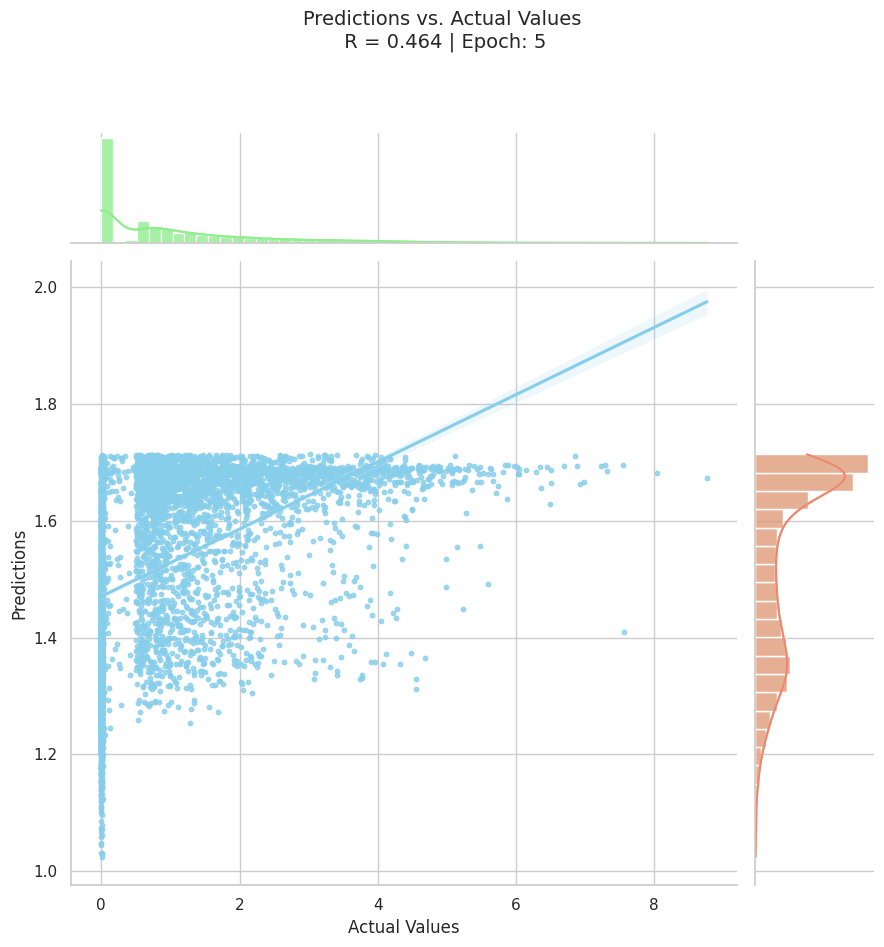

In [59]:
preds = output_dict1['preds']
targets = output_dict1['targets']
save_plot(np.array(preds), np.array(targets), 5, save_path, f"plot_epoch_{5}.png")

In [43]:
model_save_path = save_path+'/model_checkpoints/model_epoch_10.pt'
model.load_state_dict(torch.load(Path(model_save_path)))

<All keys matched successfully>

In [44]:
output_dict2 = test_model(model, test_loader, device)

Test R-value: 0.6355
Test MAE: 0.9147
Test MSE: 1.2062
Test RMSE: 1.0983
Test R2: 0.2582
Test Spearman rho: 0.7434


In [45]:
r_score = output_dict2['r_value']
print(f"Final best R-score: {r_score}")

Final best R-score: 0.6355099007032753


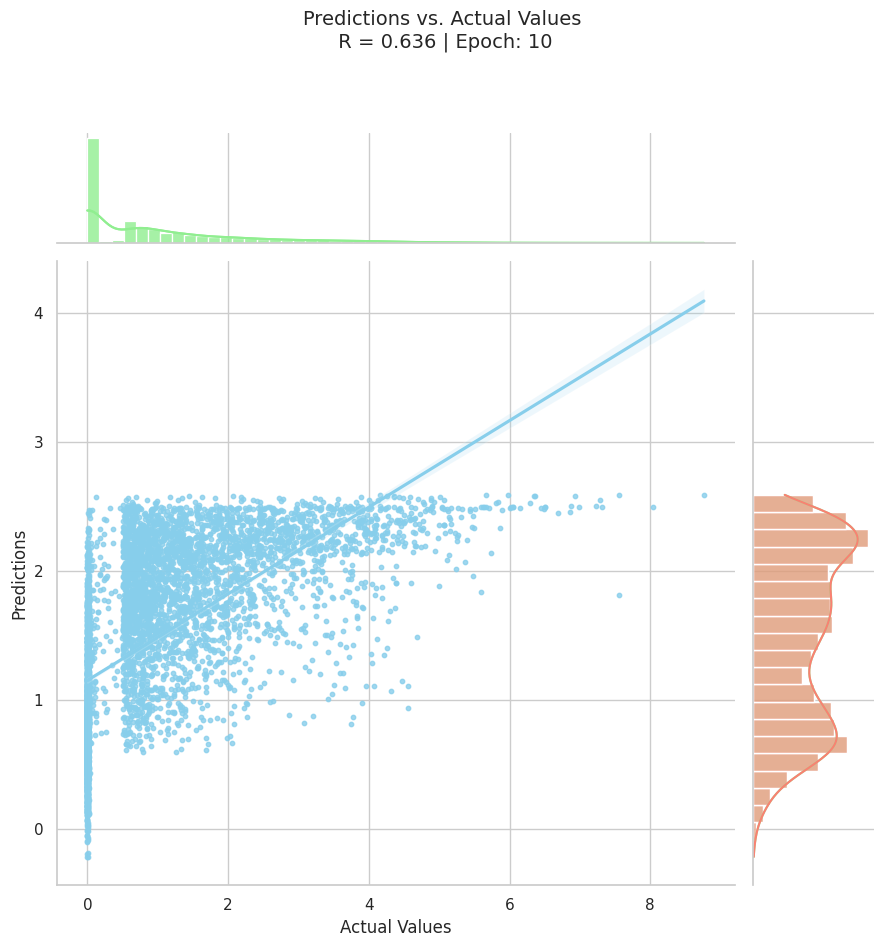

In [60]:
preds = output_dict2['preds']
targets = output_dict2['targets']
save_plot(np.array(preds), np.array(targets), 10, save_path, f"plot_epoch_{10}.png")

In [47]:
model_save_path = save_path+'/model_checkpoints/model_epoch_15.pt'
model.load_state_dict(torch.load(Path(model_save_path)))

<All keys matched successfully>

In [48]:
output_dict3 = test_model(model, test_loader, device)

Test R-value: 0.6979
Test MAE: 0.6383
Test MSE: 0.8360
Test RMSE: 0.9143
Test R2: 0.4859
Test Spearman rho: 0.7822


In [49]:
r_score = output_dict3['r_value']
print(f"Final best R-score: {r_score}")

Final best R-score: 0.6978751548508432


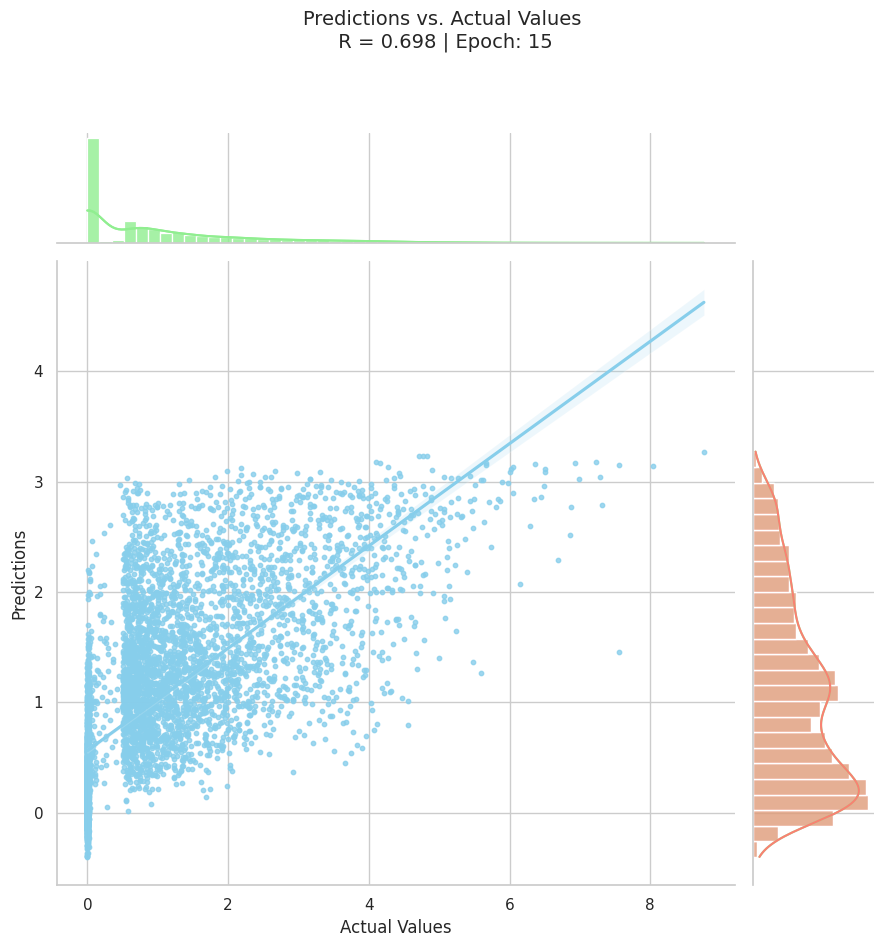

In [61]:
preds = output_dict3['preds']
targets = output_dict3['targets']
save_plot(np.array(preds), np.array(targets), 15, save_path, f"plot_epoch_{15}.png")

In [55]:
model_save_path = save_path+'/model_checkpoints/model_epoch_20.pt'
model.load_state_dict(torch.load(Path(model_save_path)))

<All keys matched successfully>

In [56]:
output_dict4 = test_model(model, test_loader, device)

Test R-value: 0.7631
Test MAE: 0.5761
Test MSE: 0.6906
Test RMSE: 0.8310
Test R2: 0.5753
Test Spearman rho: 0.8319


In [57]:
r_score = output_dict4['r_value']
print(f"Final best R-score: {r_score}")

Final best R-score: 0.7630767676219496


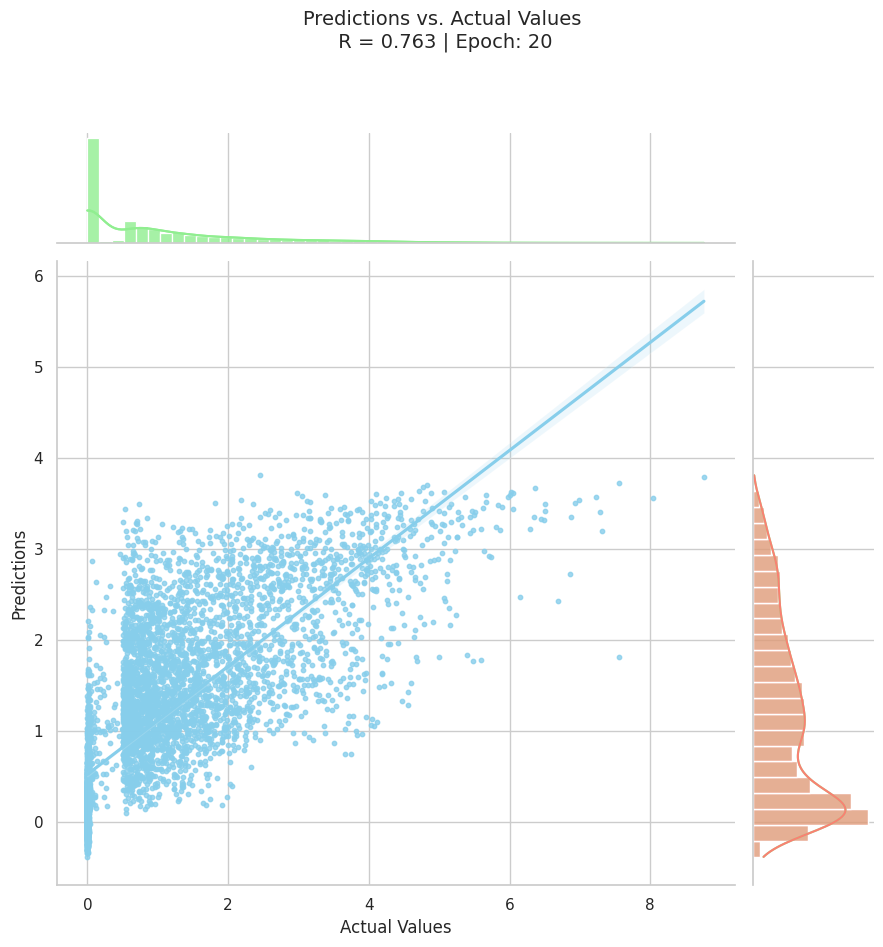

In [62]:
preds = output_dict4['preds']
targets = output_dict4['targets']
save_plot(np.array(preds), np.array(targets), 20, save_path, f"plot_epoch_{20}.png")